# Usar un clasificador de imagenes

## Introducion

Para este notebook, vamos a abrir una imagen, preprocesar esta para su entrada y vamos a clasificarla con un modelo de tipo ResNet34

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision.transforms import v2 as transforms
from torchvision.transforms import Compose
from torchvision.models import resnet34, ResNet34_Weights



In [2]:
### Parametros Iniciales

# Si tu equipo contiene una GPU con CUDA:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('GPU disponible')
# Si tu equipo es mac con AppleSilicon:
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print('Acelerador MPS disponible')
# O en CPU como la plebe:
else:
    device = torch.device('cpu')
    print('CPU disponible')


GPU disponible


## Abrir una imagen

Primero vamos a abrir una imagen cualquiera que esperamos que el modelo identifique

(-0.5, 899.5, 899.5, -0.5)

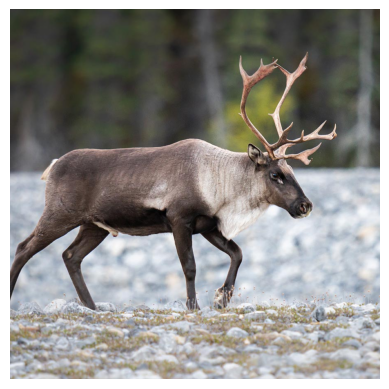

In [3]:
path = '../caribou.jpg'

# Cargamos la imagen
imagen = Image.open(path)

# Visualizamos en matplotlib
plt.imshow(imagen)
plt.axis('off')

## Modelo

`Torchvision` contiene internamente las arquitecturas de modelos comunmente utilizados.
Vamos a usar un modelo pequeño (ResNet34) con los pesos entrenados con ImageNet.
Y revisaremos que reporta este modelo al pasarle esa imagen.

In [4]:
# Cargamos el modelo
pesos = ResNet34_Weights.DEFAULT # Si uno pone el string "Default" es lo mismo
modelo = resnet34(weights=pesos)
modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

El modelo de entrada espera un tensor de 4 dimensiones `(batch, canales, alto, ancho)`

Ademas de que los valores de los pixeles deben estar en el rango $[0, 1]$

Torchvision provee una forma de construir ciertas transformaciones y armar un pipeline para estas.
Este es un ejemplo que toma la imagen, transforma a un tensor con tipo float32 escalado entre $[0,1]$, reescala a `256x256`, hace un corte central de tamaño `224x224`, y normaliza según el promedio de canales de ImageNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0643523..2.6021063].


torch.Size([1, 3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

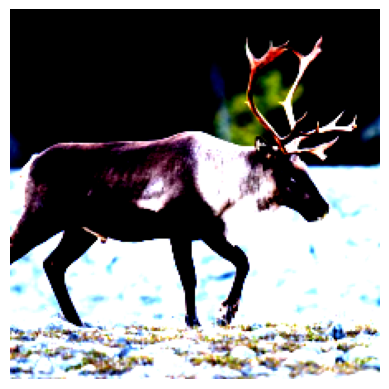

In [5]:
# transformacion

transformaciones = Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(size=(224, 224)),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Preprocesamos la imagen
imtensor = transformaciones(imagen).unsqueeze(0)
print(imtensor.shape)

# Visualizamos la imagen preprocesada
imnumpy = imtensor.numpy().squeeze().transpose(1, 2, 0)
plt.imshow(imnumpy)
plt.axis('off')

## Inferencia

In [6]:
# Pasamos la imagen por el modelo
pred = modelo(imtensor)

# Obtenemos un tensor de 1000 clases
print(pred.shape)
# quitamos el batch y aplicamos softmax
pred_class = pred.squeeze(0).softmax(0)

class_id = pred_class.argmax().item()
score = pred_class[class_id].item()
categoria = pesos.meta['categories'][class_id]

print(f'Clase: {class_id} - {categoria} - Score: {score:.2%}')

torch.Size([1, 1000])
Clase: 350 - ibex - Score: 96.52%


Confundió al caribú con un íbice (Una cabra montañesa)...

In [9]:
top_k = 10
vals, idexs = pred_class.topk(top_k)

for ix, (val, idx) in enumerate(zip(vals, idexs)):
    print(f'TOP {ix+1} - {val.item():.2%} - {pesos.meta["categories"][idx.item()]}')

TOP 1 - 96.52% - ibex
TOP 2 - 0.98% - bighorn
TOP 3 - 0.78% - hartebeest
TOP 4 - 0.46% - impala
TOP 5 - 0.29% - ram
TOP 6 - 0.21% - ox
TOP 7 - 0.16% - gazelle
TOP 8 - 0.15% - long-horned beetle
TOP 9 - 0.05% - weevil
TOP 10 - 0.02% - water buffalo


Prueben con cualquier otra imagen y revisen que tan bien clasifica.